In [2]:
import numpy as np
import pandas as pd
from multiply_linear_regression import LinearRegression as lr
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, HTML

from pandas.plotting import scatter_matrix
from pandas.plotting import parallel_coordinates

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA as sklearnPCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.datasets.samples_generator import make_blobs

### Análise descritiva dos dados
Os dados usados para encontrar a regressão linear múltipla possuem vários exemplos e várias variáveis observadas. Cada uma das variáveis representa uma disciplina do primeiro período do curso de ciência da computação na UFCG. A ideia neste estudo é construir um modelo capaz de prever ou verificar correlação entre as notas em disciplinas do primeiro período e o CRA do aluno no fim do curso.

In [3]:
df = pd.DataFrame(pd.read_csv("data/sample_treino.csv", sep=',', encoding = "utf-8"))
HTML(df.to_html())

Todas as variáveis estão na mesma escala com valores bem distribuídos e não discrepantes. Isso indica que o estudo será feito com os valores das variáveis do jeito que estão.

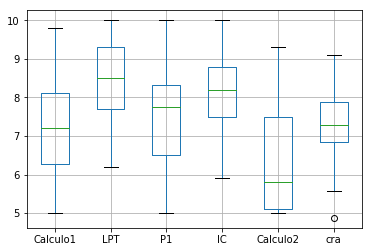

In [3]:
df.boxplot(return_type='axes')
plt.show()

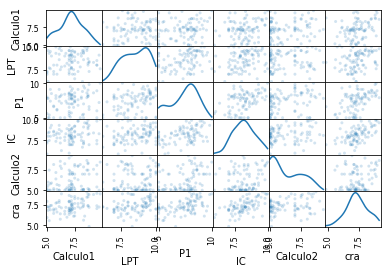

In [4]:
scatter_matrix(df, alpha=0.2, diagonal='kde')
plt.show()

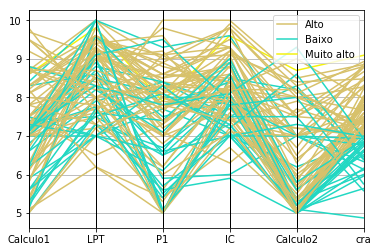

In [7]:
def addNewTypeColumn(value):
    #Menor que 4 o aluno nunca teria se formado. Teria sido reprovado, 
    #por isso não faz sentido colocar um grupo para um CRA menor que 4
    if( 4 <= float(value) < 7):
        return "Baixo"
    elif(7 <= float(value) < 9):
        return "Alto"
    else:
        return "Muito alto"

df["cra_type"] = df["cra"].apply(lambda x : addNewTypeColumn(x))
parallel_coordinates(df, "cra_type")
plt.show()

O gráfico acima mostra a ligação entre as notas do primeiro período com o CRA final do aluno. As linhas "marrons" mostram alunos que terminaram com um CRA alto. Observe que muitos deles pagaram a cadeira de Cálculo 2 com uma nota baixa. Porém os mesmos alunos pagaram cálculo 1 com uma nota alta. Agora olhando para P1 que é uma cadeira importante do curso

## Modelagem

Nesta seção será gerado o modelo de regressão linear para preve o CRA do aluno baseado em suas notas. O modelo gerado será um modelo de regressão múltipla em que a variável alvo será o CRA escrito como combinação linear das outras notas. O intuito é encontrar uma função $\hat f$ que se aproxime da função $f$ real. A função $\hat f$ estimada a partir de uma amostra de dados para cada observação i será dada por: <br><br> 
$\hat f(x) = \hat w_0 + \hat w_1x_1 ... \hat w_jx_j ... \hat w_dx_d = \sum_{j=0}^d (w_jh_j(x^i)) + e$ 

Em notação matricial temos que <br><br> 
$ Y = w^TH + e$ <br><br> 
em que $H$ é a matriz de observações e $w^T$ é o vetor de parâmetros. Portanto, temos operações entre matrizes.

### Funções usadas
Nesta seção serão descritas as funções usadas para o cálculo da regressão linear múltipla. A função custo juntamente com suas derivadas serão apresentadas juntamente com os passos seguidos para o cálculo dos parâmetros.

**Função erro (custo)** <br>

$RSS(w) = \sum_{i=1}^N (y_i- [h(x^i)^T w_j]) ^ 2 = (y - Hw) ^ T (y - Hw)$ 

Onde j é o índce do parâmetro na observação e $H$ e $w$ são vetores.

**Derivadas e função gradiente**
Para calcular o mínimo da função custo é necessário encontrar a sua derivada em relação a cada uma daas variáveis. A função resultante do processo de derivação da-se o nome de **gradiente** e é dado por

$\nabla RSS(w) = \nabla[(Y - Hw)^T(Y - Hw)] = -2H^T(y-Hw)$

O gradiente nada mais é do que um vetor resultante que indica a taxa pela qual a função decresce mais rapidamente. Cada dimensão do vetor é a derivada da função custo em relação a um único atributo e considerando os outros como valores constantes.

In [3]:
Y = np.asmatrix(df["cra"].values).T
data = df.loc[:, ~df.columns.str.contains('cra', 'cra_type')]
H = np.asmatrix(data.values)    

data_X_train, data_X_test, target_Y_train, target_Y_test = train_test_split(H, Y, test_size=0.3, random_state=42)
#hiperparameters
alpha = 0.00001

lm = lr(data_X_train, target_Y_train, alpha)

MSE: 0.500642 


O modelo gerado terá 5 dimensões e isso dificulta a visualização

In [9]:
pd.DataFrame(zip(data.columns, np.array(lm.coef_).reshape(-1,).tolist()), columns=["Features","EstimatedCoefficients"])

Features  EstimatedCoefficients
0  Calculo1               0.106265
1       LPT               0.060763
2        P1               0.232603
3        IC               0.472656
4  Calculo2               0.088452

In [5]:
cra_pred = lm.predict(data_X_test)
cra_pred = np.array(cra_pred).reshape(-1,).tolist()

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(target_Y_test, cra_pred))
    
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_Y_test,cra_pred)) 


Mean squared error: 0.59
Variance score: -0.81


In [1]:
data_X_train_sk, data_X_test_sk, target_Y_train_sk, target_Y_test_sk = train_test_split(H, np.array(df["cra"]), test_size=0.3, random_state=42)
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
res = regr.fit(data_X_train_sk, target_Y_train_sk)

# Make predictions using the testing set
cra_Y_pred = regr.predict(data_X_test_sk)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(target_Y_test_sk, cra_Y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_Y_test_sk, cra_Y_pred))

pd.DataFrame(zip(data.columns, regr.coef_), columns=["Features","EstimatedCoefficients"])

# Plot outputs
#plt.scatter(data_X_test, target_Y_test,  color='black')
#plt.plot(data_X_test, cra_Y_pred, color='blue', linewidth=3)

#plt.xticks(())
#plt.yticks(())

#plt.show()

NameError: name 'train_test_split' is not defined

Observando os parâmetros das duas funções, a diferença não é muito grande. Apenas os coeficientes das features "Cáĺculo 1" e "LPT" apresentaram uma diferença maior. O erro e a variância do score também foram semelhantes, o que indica que o algoritmo funcionou bem para essa amostra de dados.

## Matriz de confusão

A matriz de confusão mostra o quanto o modelo acertou e errou os valores da variável resposta. Neste caso não há como prever o valor da variável resposta por ela ser contínua. Então as variáveis foram agrupadas em classes e o modelo foi testado. Se acertar conta um acerto e se errar contabiliza um erro. Abaixo estão os resultados.

### Modelo

In [42]:
def generate_confusion_matrix(y_test, y_pred):
    ac = 0
    er = 0
    
    for i in range(0, len(y_test)):
        if y_test[i] == y_pred[i] :
            ac = ac + 1
        else :
            er = er + 1
    return [ac, er]

class_test = np.array(map(addNewTypeColumn, target_Y_test)).reshape(-1,).tolist()
class_pred = np.array(map(addNewTypeColumn, cra_pred)).reshape(-1,).tolist()


#Considerando a classe "Alto" como sendo a classe positiva
results = generate_confusion_matrix(class_test, class_pred)

print "ACERTOU %d" %(results[0])
print "ERROU %d" %(results[1])

#Y = target_Y_test.apply(lambda x : addNewTypeColumn(x))

ACERTOU 16
ERROU 11


### Modelo do scikit learn

In [43]:
class_test = np.array(map(addNewTypeColumn, target_Y_test_sk)).reshape(-1,).tolist()
class_pred = np.array(map(addNewTypeColumn, cra_Y_pred)).reshape(-1,).tolist()

#Considerando a classe "Alto" como sendo a classe positiva
results = generate_confusion_matrix(class_test, class_pred)

print "ACERTOU %d" %(results[0])
print "ERROU %d" %(results[1])

#Y = target_Y_test.apply(lambda x : addNewTypeColumn(x))

ACERTOU 16
ERROU 11
